(17, 154, 423)


<IPython.core.display.Javascript object>


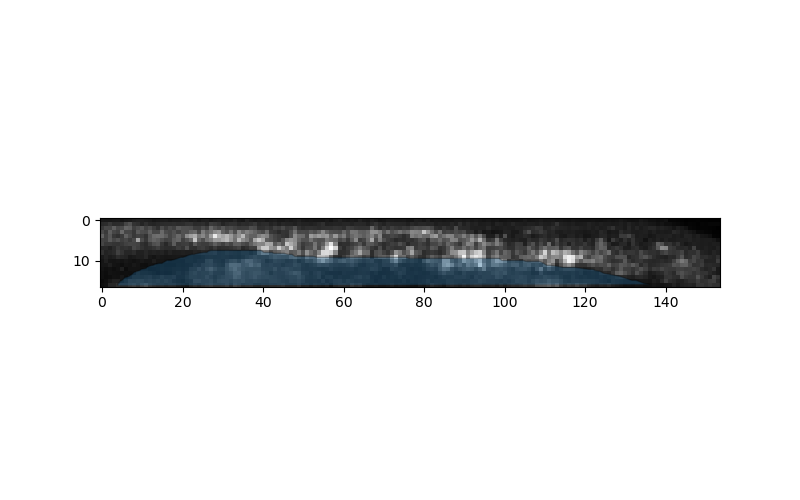

<IPython.core.display.Javascript object>


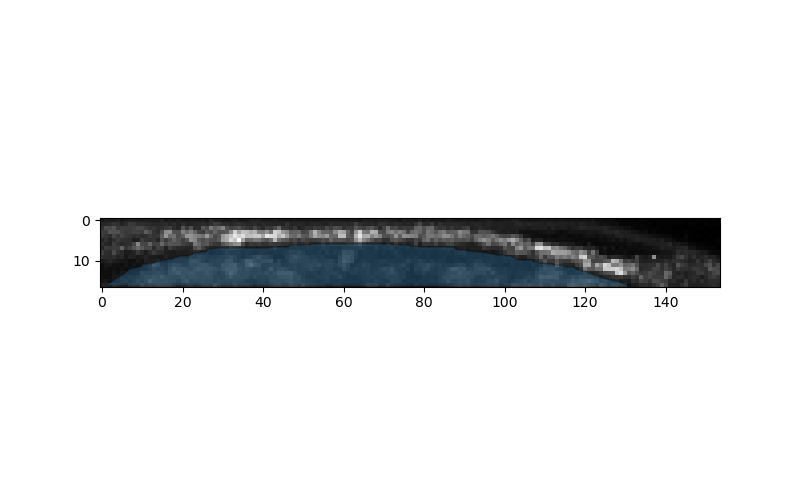

<IPython.core.display.Javascript object>


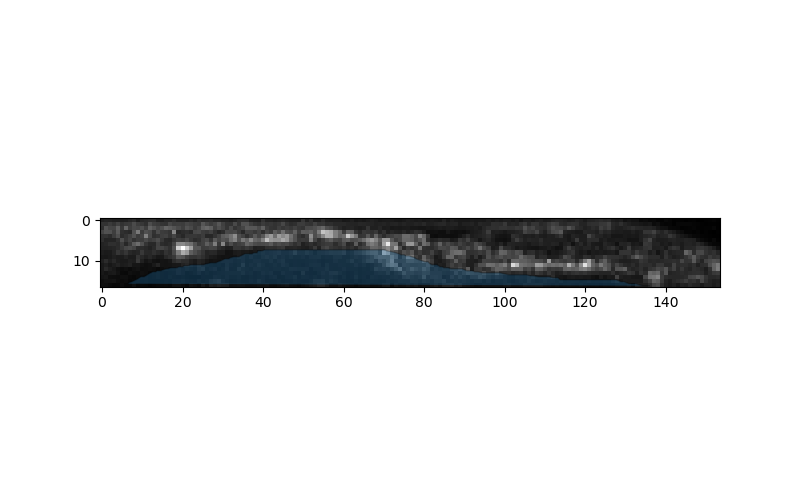

<IPython.core.display.Javascript object>


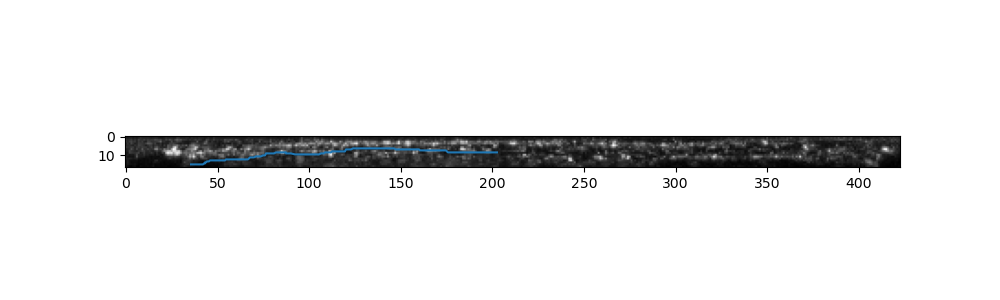

In [54]:
%matplotlib notebook

import numpy as np
from tifffile import imread, imsave
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.widgets import LassoSelector
import pickle

ruta_archivo = r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 150623 c381ECadGFP UASctMLCK\3-\3- t\3-.tif - T=0.tif"

imagen = imread(ruta_archivo)
print(imagen.shape) #(z,y,x)
proyeccion_maxima_z = np.max(imagen, axis=0)
proyeccion_maxima_y = np.max(imagen, axis=1)
#proyeccion_maxima_x = np.max(imagen, axis=2)
# Dividir la imagen en tres partes en el eje x
dividido_x = np.array_split(imagen, 3, axis=2)
proyeccion_maxima_x1 = np.max(dividido_x[0], axis=2)
proyeccion_maxima_x2 = np.max(dividido_x[1], axis=2)
proyeccion_maxima_x3 = np.max(dividido_x[2], axis=2)

class SelectFromImage(object):
    def __init__(self, ax, title):
        self.ax = ax
        self.title = title
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None

    def onselect(self, verts):
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        self.ax.figure.canvas.draw()

        # Guardar las coordenadas de los vértices
        with open(f'{self.title}_coords.pkl', 'wb') as f:
            pickle.dump(verts, f)
            
#fig_z, ax_z = plt.subplots()
#ax_z.imshow(proyeccion_maxima_z, cmap='gray')

#fig_x, ax_x = plt.subplots(figsize=(10, 20))
#ax_x.imshow(proyeccion_maxima_x, cmap='gray')
#elector_x = SelectFromImage(ax_x, 'X')

fig_x1, ax_x1 = plt.subplots(figsize=(8, 5))
ax_x1.imshow(proyeccion_maxima_x1, cmap='gray')
selector_x1 = SelectFromImage(ax_x1, 'X1')

fig_x2, ax_x2 = plt.subplots(figsize=(8, 5))
ax_x2.imshow(proyeccion_maxima_x2, cmap='gray')
selector_x2 = SelectFromImage(ax_x2, 'X2')

fig_x3, ax_x3 = plt.subplots(figsize=(8, 5))
ax_x3.imshow(proyeccion_maxima_x3, cmap='gray')
selector_x3 = SelectFromImage(ax_x3, 'X3')



fig_y, ax_y = plt.subplots(figsize=(10, 3))
ax_y.imshow(proyeccion_maxima_y, cmap='gray')
selector_y = SelectFromImage(ax_y, 'Y')



plt.show()


<IPython.core.display.Javascript object>


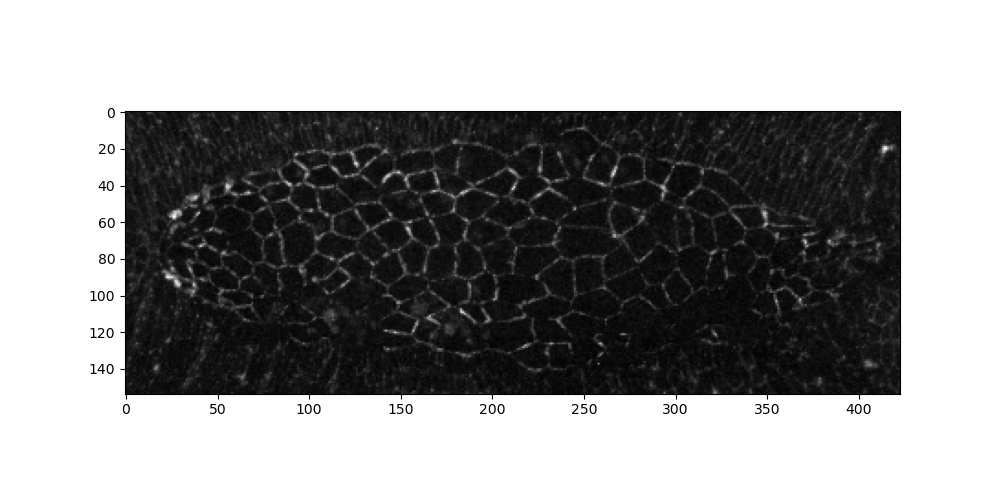

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import binary_fill_holes
from skimage.morphology import convex_hull_image
import pickle

#ruta_archivo = r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 150623 c381ECadGFP UASctMLCK\3-\3- t\3-.tif - T=30.tif"

imagen = imread(ruta_archivo)


# Crear la máscara 3D
shape = imagen.shape  # Asumimos que la imagen original tenía tres dimensiones (z, y, x)
mask_3d_x = np.zeros(shape, dtype=bool)

# Para cada tercio del eje x
x_coords_files = ['X1_coords.pkl', 'X2_coords.pkl', 'X3_coords.pkl']
x_thirds = np.array_split(np.arange(shape[2]), 3)

for i in range(3):
    coord_file = x_coords_files[i]
    x_range = x_thirds[i]

    # Cargar las coordenadas del archivo pickle
    with open(coord_file, 'rb') as f:
        coords = pickle.load(f)

    # Convertir las coordenadas a enteros
    coords = np.array(coords, dtype=int)

    for x in x_range:
        # Crear una máscara 2D para la "rebanada" actual
        mask_2d = np.zeros((shape[0], shape[1]), dtype=bool)
        mask_2d[coords[:, 1], coords[:, 0]] = True

        # Aplicar la función convex_hull_image para rellenar la forma
        mask_2d_filled = convex_hull_image(mask_2d)

        # Asignar la máscara rellena a la "rebanada" actual en la máscara 3D
        mask_3d_x[:, :, x] = mask_2d_filled 

# Repetir el proceso para el eje y
with open('Y_coords.pkl', 'rb') as f:
    coords = pickle.load(f)

coords = np.array(coords, dtype=int)
mask_3d_y = np.zeros(shape, dtype=bool)

for y in range(shape[1]):
    mask_2d = np.zeros((shape[0], shape[2]), dtype=bool)
    mask_2d[coords[:, 1], coords[:, 0]] = True
    mask_2d_filled = convex_hull_image(mask_2d)
    mask_3d_y[:, y, :] = mask_2d_filled 

# Intersección de las máscaras
mask_intersection = np.logical_and(mask_3d_x, mask_3d_y)

# Poner a 0 los valores de la imagen original donde mask_intersection es True
imagen[mask_intersection] = 0

# Graficar las proyecciones
proyeccion_maxima_z = np.max(imagen, axis=0)
proyeccion_maxima_y = np.max(imagen, axis=1)
proyeccion_maxima_x = np.max(imagen, axis=2)

fig_z, ax_z = plt.subplots(figsize=(10, 5))
ax_z.imshow(proyeccion_maxima_z, cmap='gray')

#fig_x, ax_x = plt.subplots()
#ax_x.imshow(proyeccion_maxima_x, cmap='gray')

#fig_y, ax_y = plt.subplots()
#ax_y.imshow(proyeccion_maxima_y, cmap='gray')

plt.show()

In [49]:
### from tifffile import imsave
import os
from tifffile import imread, imsave
import numpy as np

def apply_filter(image_path, x_coords_files=['X1_coords.pkl', 'X2_coords.pkl', 'X3_coords.pkl'], y_coords_file='Y_coords.pkl'):
    imagen = imread(image_path)
    shape = imagen.shape  # Assume that the original image had three dimensions (z, y, x)
    mask_3d_x = np.zeros(shape, dtype=bool)

    # Para cada tercio del eje x
    x_coords_files = ['X1_coords.pkl', 'X2_coords.pkl', 'X3_coords.pkl']
    x_thirds = np.array_split(np.arange(shape[2]), 3)

    for i in range(3):
        coord_file = x_coords_files[i]
        x_range = x_thirds[i]

        # Cargar las coordenadas del archivo pickle
        with open(coord_file, 'rb') as f:
            coords = pickle.load(f)

        # Convertir las coordenadas a enteros
        coords = np.array(coords, dtype=int)

        for x in x_range:
            # Crear una máscara 2D para la "rebanada" actual
            mask_2d = np.zeros((shape[0], shape[1]), dtype=bool)
            mask_2d[coords[:, 1], coords[:, 0]] = True

            # Aplicar la función convex_hull_image para rellenar la forma
            mask_2d_filled = convex_hull_image(mask_2d)

            # Asignar la máscara rellena a la "rebanada" actual en la máscara 3D
            mask_3d_x[:, :, x] = mask_2d_filled 

    # Repetir el proceso para el eje y
    with open('Y_coords.pkl', 'rb') as f:
        coords = pickle.load(f)

    coords = np.array(coords, dtype=int)
    mask_3d_y = np.zeros(shape, dtype=bool)

    for y in range(shape[1]):
        mask_2d = np.zeros((shape[0], shape[2]), dtype=bool)
        mask_2d[coords[:, 1], coords[:, 0]] = True
        mask_2d_filled = convex_hull_image(mask_2d)
        mask_3d_y[:, y, :] = mask_2d_filled 

    # Intersección de las máscaras
    mask_intersection = np.logical_and(mask_3d_x, mask_3d_y)

    # Poner a 0 los valores de la imagen original donde mask_intersection es True
    imagen[mask_intersection] = 0

    # Graficar las proyecciones
    proyeccion_maxima_z = np.max(imagen, axis=0)
    proyeccion_maxima_y = np.max(imagen, axis=1)
    proyeccion_maxima_x = np.max(imagen, axis=2)
        # ...rest of your code...

    # Return the filtered image and z-projection
    return imagen, proyeccion_maxima_z

def process_files(file_paths, output_folder):
    for file_path in file_paths:
        filtered_image, projection_z = apply_filter(file_path)

        # Save the z-projection as .tif
        output_path = os.path.join(output_folder, os.path.basename(file_path))
        imsave(output_path, projection_z)

# List of input files
#input_files = [
#    r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 230523 c381ECadGFP\2-\2- t\2-.tif - T=0.tif"
#]
# Starting and ending numbers (inclusive)
start = 52
end = 107

# Base file path without the number
base_path = r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 150623 c381ECadGFP UASctMLCK\4-\4- t\4-.tif - T="

# Generate the list of file paths
input_files = [base_path + f"{i}.tif" for i in range(start, end+1)]



# Output folder
output_folder = r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 150623 c381ECadGFP UASctMLCK\4-\4- filtro"

# Process all files
process_files(input_files, output_folder)


C:\Users\Jon\AppData\Local\Temp\ipykernel_19648\3876160568.py:71: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_path, projection_z)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jon\\Documents\\Master Biofísica\\TFM\\PELIS MOSCAS - ORIGINALES\\22126 150623 c381ECadGFP UASctMLCK\\4-\\4- t\\4-.tif - T=107.tif'